In [1]:
%cd ..
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # use cpu because I'm training on gpu

# from thumbs.experiments.pokemon_conditional_types_v4_deep import PokemonExperiment
from thumbs.viz import show_samples, visualize_preprocessed_image
from thumbs.data import load_and_preprocess_image
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt


/home/anthony/workspace/yt-data


2023-09-03 11:54:39.874224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 821 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

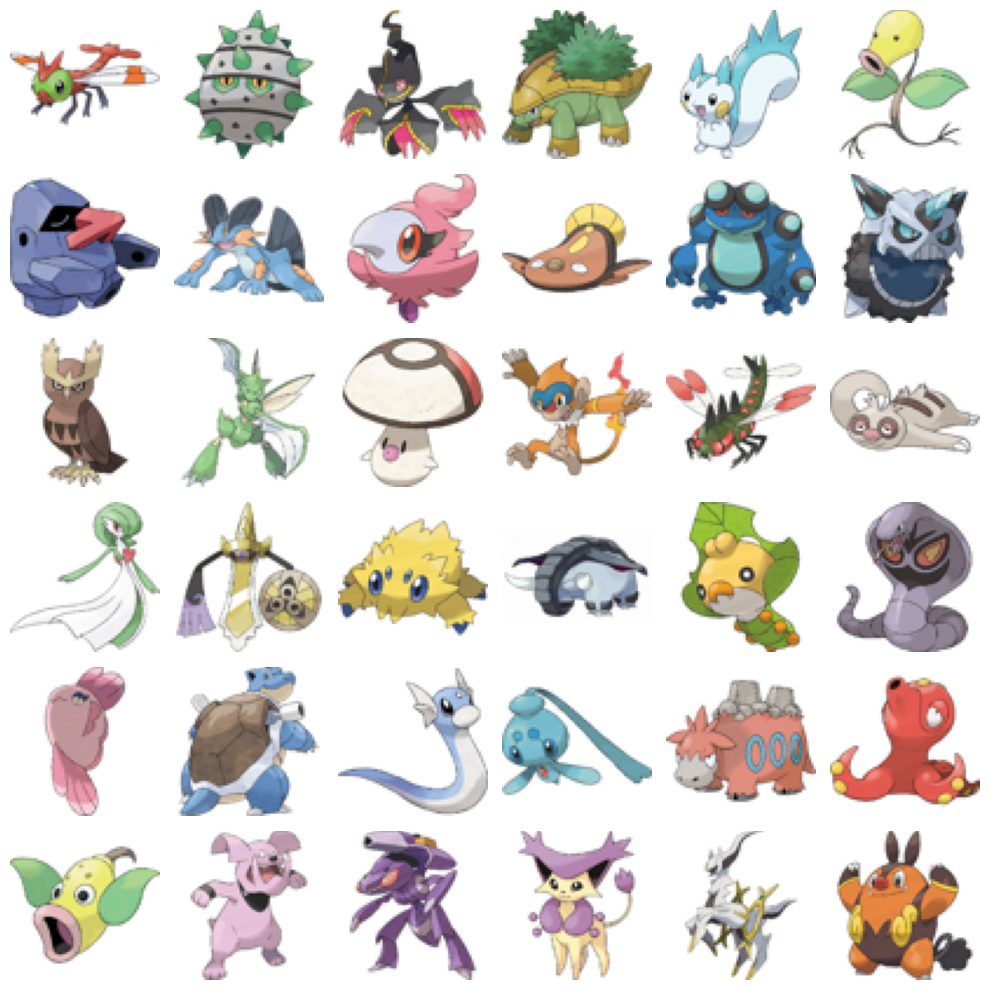

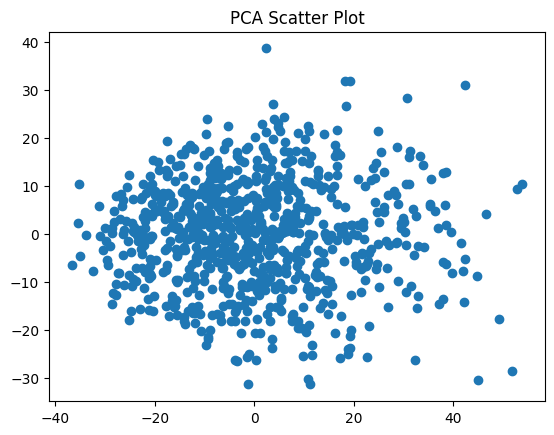

2023-09-03 11:54:44.346400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
from thumbs.data import get_pokemon_data256

data = tf.data.Dataset.from_tensor_slices(get_pokemon_data256((64,64,3))).batch(1).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [84]:
from thumbs.params import DiffusionHyperParams

mparams = DiffusionHyperParams(
    learning_rate=0.0002,
    batch_size=128,
    adam_b1=0.5,
    iterations=10000,
    sample_interval=1,

    T=300,
    beta=0.008

)

print(f'Datset length {len(data)}')

def forward_diffusion_sample(x_0, t, device='/cpu:0'):
    """
    x_0: Initial images, shape (batch_size, height, width, channels)
    t: timestep
    beta_schedule: A list or tensor of noise levels, beta, at each timestep
    device: 'CPU:0' or 'GPU:0' etc.
    """
    with tf.device(device):
        # x = tf.cast(x_0, tf.float32) # TODO Maybe don't need?
        x = x_0
        
        # Loop through the timesteps up to t
        final_noise = None
        for i in range(t):
            beta = mparams.beta_schedule[i]  # Get beta for this timestep
            noise = tf.random.normal(shape=x.shape, mean=0., stddev=1.)  # Generate random noise
            noise_scaled = tf.math.sqrt(beta) * noise  # Scale the noise
            if final_noise is None:
                final_noise = noise_scaled
            else:
                final_noise = final_noise + noise_scaled
            x = x * (1 - beta) + noise_scaled  # Add the noise to x

    return x, final_noise

Datset length 819


## Show the noise steps

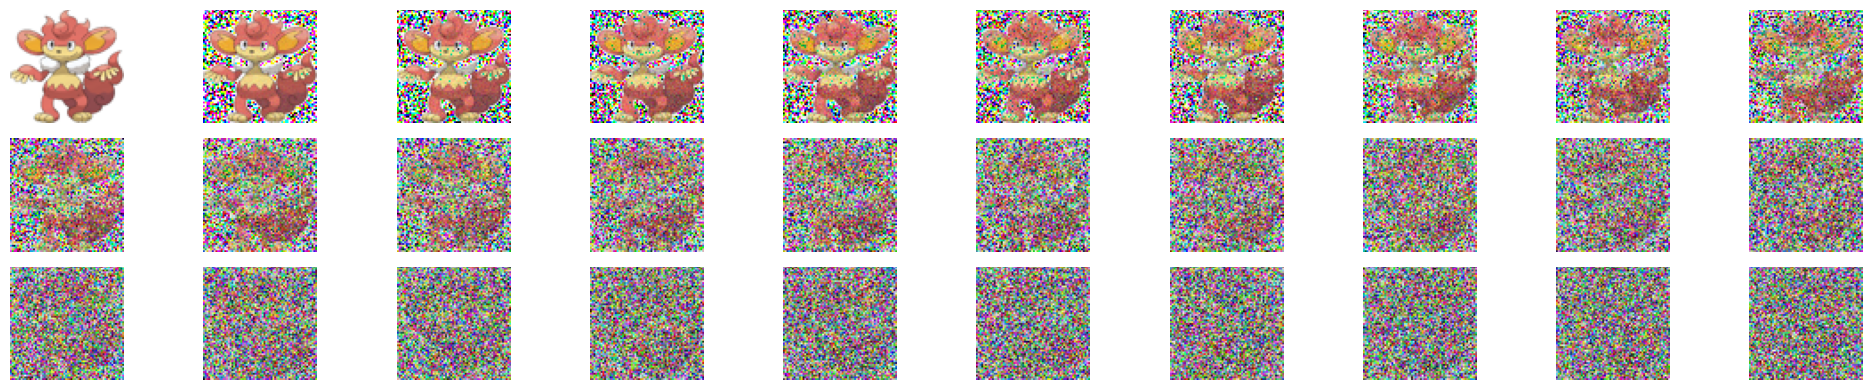

In [85]:
# Show a plot with  each image in a single row
from thumbs.util import unnormalize_image

it = iter(data)
for i in range(10):
    next(it)
item = next(it)

step_size = 10

ncols = 10
nrows = int(int(mparams.T/step_size) / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4))

last_img = None
last_noise = None
images = []

for i, t in enumerate(range(0, mparams.T, step_size)):
    img, noise = forward_diffusion_sample(item, t)
    img = unnormalize_image(img[0].numpy())
    images.append(img)


images.reverse()
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].imshow(images.pop())
        axes[i,j].axis('off')  # Hide the axes ticks and labels
        last_img = img
        last_noise = noise

plt.subplots_adjust(wspace=0.0, hspace=0)
plt.tight_layout()
plt.show()


## Make sure the noise is sufficeint by showing the overlap between T and original

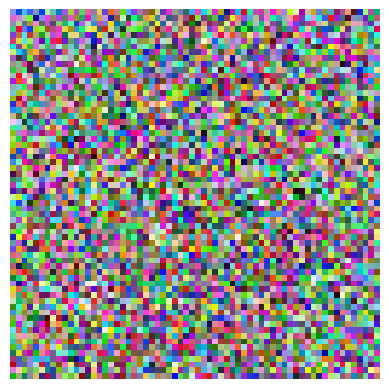

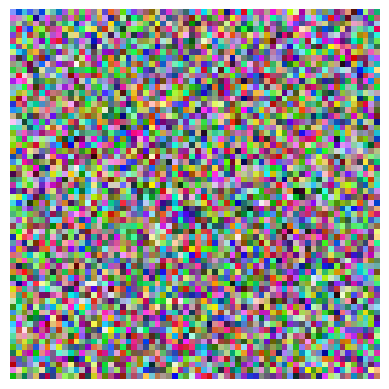

In [86]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(last_img)
plt.axis('off')
plt.show()

# Show the blended image using matplotlib, since we're sticking to Python libraries here
recovered = (last_img - last_noise[0]).numpy().astype(np.uint8)
plt.imshow(recovered)
plt.axis('off')
plt.show()

